In [2]:
import drawsvg as draw
import operator

(0.0, 200.0, 400.0, 0.0) (30.0, 180.0, 390.0, 30.0)
30.0 180.0
66.0 135.0
102.0 165.0
138.0 150.0
174.0 120.0
210.0 135.0
246.0 105.0
282.0 120.0
318.0 90.0
354.0 45.0
390.0 30.0


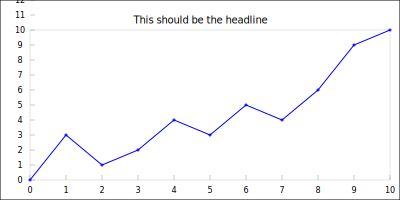

In [52]:
class TRF:
    def __init__(self, x0, x1, xn0, xn1):
        self.x0 = x0
        self.x1 = x1
        self.xn0 = xn0
        self.xn1 = xn1

    def o2n(self, x):
        return self.xn0 + (x - self.x0) / (self.x1 - self.x0) * (self.xn1 - self.xn0)
    
    def n2o(self, xn):
        return self.x0 + (xn - self.xn0) / (self.xn1 - self.xn0) * (self.x1 - self.x0)
    
    # define add for TRF:
    def __add__(self, other):
        return TRF(self.x0, self.x1, self.xn0 + other.xn0, self.xn1 + other.xn1)
    
class SPlotter:
    def __init__(self, size, border=None, rect=None, pixel_scale=1):
        self.size = size
        self.trf_xph = TRF(0, size[0], 0, size[0])
        self.trf_yph = TRF(0, size[1], size[1], 0)

        self.canvas = draw.Drawing(size[0], size[1], origin=(0,0))
        self.pixel_scale = pixel_scale
        self.canvas.set_pixel_scale(pixel_scale)

        self.canvas_area = (self.trf_xph.o2n(0), self.trf_yph.o2n(0), self.trf_xph.o2n(size[0]), self.trf_yph.o2n(size[1]))
        self.border = border
                            
        self.plot_area = (self.canvas_area[0] + self.border[0], self.canvas_area[1] - self.border[1], self.canvas_area[2] - self.border[2], self.canvas_area[3] + self.border[3])

        self.trf_xplt = TRF(rect[0], rect[2], self.plot_area[0], self.plot_area[2])
        self.trf_yplt = TRF(rect[1], rect[3], self.plot_area[1], self.plot_area[3])

        self.tx = self.trf_xplt + self.trf_xph
        self.ty = self.trf_yplt + self.trf_yph

    def plot(self, x, y, stroke='black', fill='none', stroke_width=1):
        if len(x) != len(y):
            raise ValueError("x and y must have same length")
        if len(x) < 2:
            raise ValueError("x and y must have at least 2 points")
        for i, (xi, yi) in enumerate(zip(x, y)):
            nx= self.trf_xplt.o2n(xi)
            ny= self.trf_yplt.o2n(yi)
            print(nx, ny)
            self.canvas.append(draw.Circle(nx, ny, 1, fill=fill, stroke=stroke, stroke_width=stroke_width))
            if i > 0:
                self.canvas.append(draw.Line(nox, noy, nx, ny, stroke=stroke, stroke_width=stroke_width))
            nox = nx
            noy = ny

    def ticks(self, intervals=11):
        for i in range(0, intervals):
            xti = self.trf_xplt.o2n(i)
            yt = self.trf_yplt.o2n(0)
            self.canvas.append(draw.Line(xti, yt, xti, yt-5, stroke='black', stroke_width=0.2))
            self.text(str(i), 8, xti, yt+10)
            xt = self.trf_xplt.o2n(0)
            yti = self.trf_yplt.o2n(i)
            self.canvas.append(draw.Line(xt, yti, xt+5, yti, stroke='black', stroke_width=0.2))
            self.text(str(i), 8, xt-10, yti)
            # self.canvas.append(draw.Line(self.trf_xplt.o2n(i), self.trf_yplt.o2n(0), self.trf_xplt.o2n(i), self.trf_yplt.o2n(0.2), stroke='black', stroke_width=0.2))
            # self.canvas.append(draw.Line(self.trf_xplt.o2n(0), self.trf_yplt.o2n(i), self.trf_xplt.o2n(0.2), self.trf_yplt.o2n(i), stroke='black', stroke_width=0.2))


    def text(self, text, size, x, y):
        self.canvas.append(draw.Text(text, size, x, y, center=True))



sp = SPlotter(size=(400,200), border=(30,20,10,30), rect=(0,0,10,10))
print(sp.canvas_area, sp.plot_area)
sp.canvas.append(draw.Rectangle(sp.canvas_area[0], sp.canvas_area[3], sp.canvas_area[2]-sp.canvas_area[0], -sp.canvas_area[3]+sp.canvas_area[1], fill='white', stroke='black'))
sp.canvas.append(draw.Rectangle(sp.plot_area[0], sp.plot_area[3], sp.plot_area[2]-sp.plot_area[0], -sp.plot_area[3]+sp.plot_area[1], fill='white', stroke='gray', stroke_width=0.2))
sp.plot([0,1,2,3,4,5,6,7,8,9,10], [0,3,1,2,4,3,5,4,6,9,10], stroke='blue')
sp.text("This should be the headline", 10, sp.trf_xph.o2n(200), sp.trf_yph.o2n(180))
sp.ticks(22)
sp.canvas